# Gaussian Mixture Model (GMM)
---

A GMM model on the $2^{nd}$ and $4^{th}$ principal components of the dog and cat wavelet image data

In [2]:
# Load package
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import io
from sklearn.mixture import GaussianMixture
import os
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
import matplotlib.pyplot as plt

# Load data

In [3]:
# Load wavelet image data of dog and cat
dogdata_w_mat = io.loadmat(os.path.join('..','DATA','dogData_w.mat'))
catdata_w_mat = io.loadmat(os.path.join('..','DATA','catData_w.mat'))

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

# Combine 2 data sets into 1
CD = np.concatenate((dog_wave,cat_wave),axis=1)
CD, CD.shape

(array([[ 2,  4,  8, ...,  3,  6,  6],
        [ 7,  5, 10, ...,  7,  5,  5],
        [ 7, 36, 34, ...,  9, 25,  4],
        ...,
        [20, 15, 10, ..., 12,  3, 10],
        [39,  6, 10, ..., 28,  3, 14],
        [ 6, 10, 13, ..., 31,  3, 15]], dtype=uint8),
 (1024, 160))

In [4]:
# Singular Value Decomposition
# Subtraction with mean to normalize the data set
u,s,vT = np.linalg.svd(CD-np.mean(CD),full_matrices=0)
v = vT.T

We only use the $2^{nd}$ and $4^{th}$ principal components and then train it
with built-in function GaussianMixture

To initialize the algorithm, we must choose:
- $k$:  the number of mixture models
- Initializes parameters: mean and covariance (by default, every mixture component has zero mean and identity covariance.)

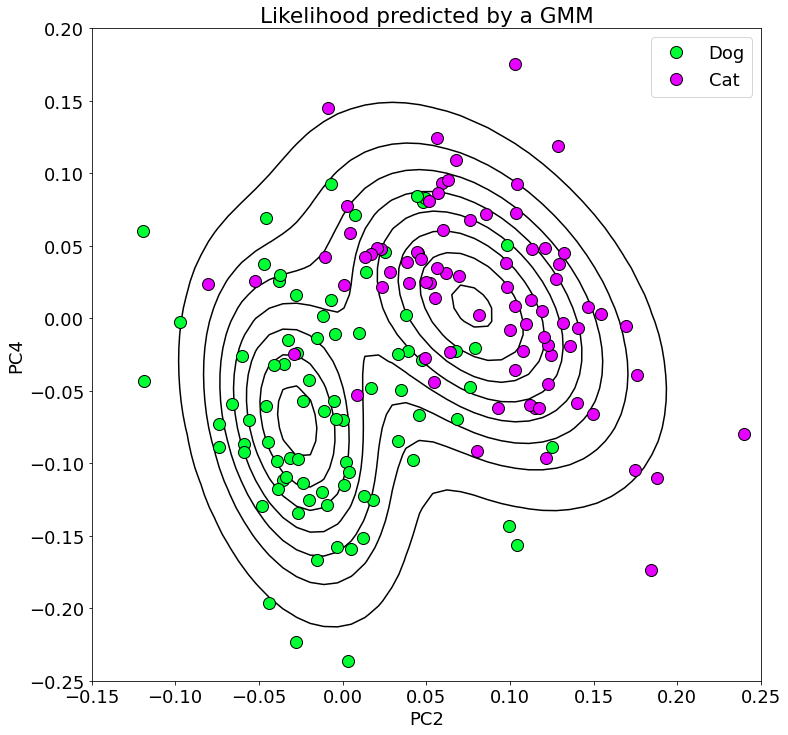

In [5]:
# get the 2nd and 4th PCs
dogcat = v[:,(1,3)]

# Use GMM with k = 2
# train it with the 2nd and 4th PCs
GMModel = GaussianMixture(n_components=2).fit(dogcat)
#AIC = GMModel.aic(dogcat)

# Plot points in the 2nd and 4th PCs
plt.plot(v[:80,1],v[:80,3],'ro',
         markerfacecolor=(0,1,0.2),markeredgecolor='k',
         ms=12, label ='Dog')
plt.plot(v[80:,1],v[80:,3],'bo',
         markerfacecolor=(0.9,0,1),markeredgecolor='k',
         ms=12, label ='Cat')

# Plot the contour
x = np.linspace(-0.15, 0.25)
y = np.linspace(-0.25, 0.2)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(GMModel.score_samples(XX))
# score_samples: Compute the log probability of X
# under the model and return the posterior distribution
# (responsibilities) of each mixture component for each element of X
# We need to use np.exp to convert from log-likelihood to likelihood
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z,levels=np.arange(3,32,4),colors='k',linestyles='solid')
plt.legend()
plt.title('Likelihood predicted by a GMM')
plt.xlabel('PC2')
plt.ylabel('PC4')
plt.show()

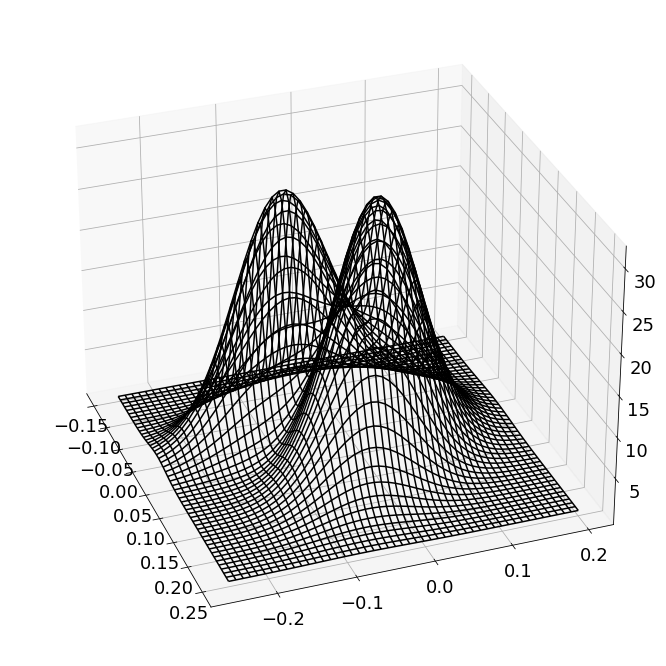

In [6]:
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.view_init(30, -20)
plt.show()

# Create a 3D animation

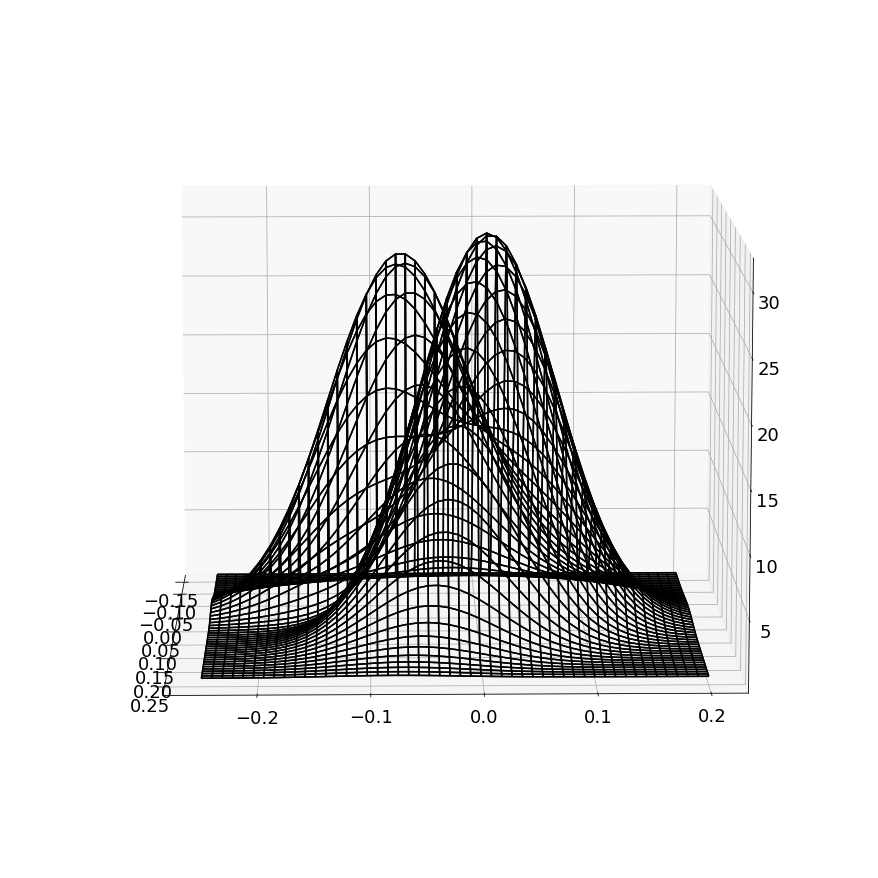

In [7]:
# Create a figure and a 3D Axes
fig = plt.figure()
ax = Axes3D(fig)

def init():
    ax.plot_wireframe(X, Y, Z, color='black')
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('GMM_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

Compare the model via AIC and BIC scores
- AIC: Akaike information criterion
- BIC: Bayesian information criterion

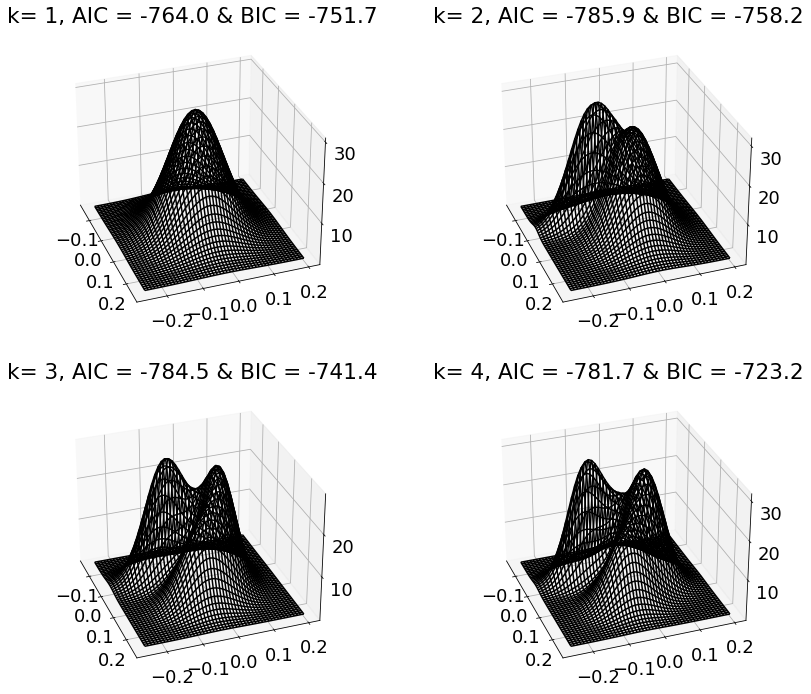

In [8]:
## AIC Scores
AIC = np.zeros(4)
BIC = np.zeros(4)
GMModels = [GaussianMixture(k+1,covariance_type='diag',max_iter=500).fit(dogcat)
          for k in range(4)]

fig,axs = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(14,12))
axs = axs.reshape(-1)

for j in range(len(axs)):
    Z = np.exp(GMModels[j].score_samples(XX))
    Z = Z.reshape(X.shape)
    AIC[j] = GMModels[j].aic(dogcat)
    BIC[j] = GMModels[j].bic(dogcat)
    axs[j].plot_wireframe(X, Y, Z, color='black')
    axs[j].view_init(30, -20)
    axs[j].set_title('k= {}, AIC = {:.1f} & BIC = {:.1f}'.format(j+1,AIC[j],BIC[j]))


Overall, k = 2 got the lowest AIC and BIC scores so the data set should be clustered into 2
which match well with our data as it contains only dog and cat images

Try corrected AIC